In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## 資料集說明

> 以2007年07月至2018年06月之台積電股票為例，利用LSTM模型做股價預測分析。

資料包含：
- 66項公司特徵指標
- 39項整體產業相關之特徵指標
- 類股指數
- 台積電月均股票價格

In [17]:
data = pd.read_excel('2330_indu_comp_sector_price.xlsx')
features_number = 107
data

,DATE,PRICE,BS_MKT_SEC_OTHER_ST_INVEST,BS_GROSS_FIX_ASSET,BS_ACCUM_DEPR,BS_LONG_TERM_INVESTMENTS,OTHER_INTANGIBLE_ASSETS_DETAILED,BS_INVEST_IN_ASSOC_CO,BS_INTEREST_&_DIVIDENDS_PAYABLE,BS_ACCRUAL,...,OTHER_INVESTING_ACT_DETAILED.1,CF_ACCT_RCV_UNBILLED_REV.1,CF_CHANGE_IN_INVENTORIES.1,CF_NET_CHNG_CASH,INC_DEC_IN_OT_OP_AST_LIAB_DETAIL.1,IS_DEFERRED_INCOME_TAX_BENEFIT,IS_COG_AND_SERVICES_SOLD.1,IS_FOREIGN_EXCH_LOSS.1,IS_INC_TAX_EXP,SECTOR_INDEX
0,200707,70.20,78064000,786850000,521614000,20636294.16,6621912.357,22837846.19,96407522,4.917643e+07,...,-9559000,-1.403105e+06,-1.818020e+06,-65063000,0,-64997.65789,45424196.58,0,3600000,103.678636
1,200708,61.73,78064000,786850000,521614000,20636294.16,6621912.357,22837846.19,96407522,4.917643e+07,...,-9559000,-1.403105e+06,-1.818020e+06,-65063000,0,-64997.65789,45424196.58,0,3600000,93.298696
2,200709,61.85,78064000,786850000,521614000,20636294.16,6621912.357,22837846.19,96407522,4.917643e+07,...,-9559000,-1.403105e+06,-1.818020e+06,-65063000,0,-64997.65789,45424196.58,0,3600000,93.420556
3,200710,62.98,79848000,800352000,540100000,20636294.16,6621912.357,22837846.19,96407522,4.917643e+07,...,7086000,-1.403105e+06,-1.818020e+06,-3342000,0,-64997.65789,45424196.58,0,4608000,95.711818
4,200711,61.03,79848000,800352000,540100000,20636294.16,6621912.357,22837846.19,96407522,4.917643e+07,...,7086000,-1.403105e+06,-1.818020e+06,-3342000,0,-64997.65789,45424196.58,0,4608000,86.092727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,201802,244.46,106452676,3143345084,2087978877,16069145.00,8102449.000,18307517.00,96407522,1.161545e+08,...,-5075930,1.329699e+07,-1.133515e+07,24391267,-8024274,-868284.00000,57937633.00,676980,10156047,171.349231
128,201803,249.37,106452676,3143345084,2087978877,16069145.00,8102449.000,18307517.00,96407522,1.161545e+08,...,-5075930,1.329699e+07,-1.133515e+07,24391267,-8024274,-868284.00000,57937633.00,676980,10156047,177.016956
129,201804,236.81,116303707,3193649080,2159381018,13171658.00,8025238.000,15663648.00,207519110,9.538655e+07,...,-2665421,1.802174e+07,-1.383592e+07,54446917,-5082157,-651196.00000,56693785.00,-2330616,15294233,170.943889
130,201805,227.05,116303707,3193649080,2159381018,13171658.00,8025238.000,15663648.00,207519110,9.538655e+07,...,-2665421,1.802174e+07,-1.383592e+07,54446917,-5082157,-651196.00000,56693785.00,-2330616,15294233,164.954545


In [18]:
print(data.columns)
print(data.shape)
len_data = data.shape[0]

Index(['DATE', 'PRICE', 'BS_MKT_SEC_OTHER_ST_INVEST', 'BS_GROSS_FIX_ASSET',
       'BS_ACCUM_DEPR', 'BS_LONG_TERM_INVESTMENTS',
       'OTHER_INTANGIBLE_ASSETS_DETAILED', 'BS_INVEST_IN_ASSOC_CO',
       'BS_INTEREST_&_DIVIDENDS_PAYABLE', 'BS_ACCRUAL',
       ...
       'OTHER_INVESTING_ACT_DETAILED.1', 'CF_ACCT_RCV_UNBILLED_REV.1',
       'CF_CHANGE_IN_INVENTORIES.1', 'CF_NET_CHNG_CASH',
       'INC_DEC_IN_OT_OP_AST_LIAB_DETAIL.1', 'IS_DEFERRED_INCOME_TAX_BENEFIT',
       'IS_COG_AND_SERVICES_SOLD.1', 'IS_FOREIGN_EXCH_LOSS.1',
       'IS_INC_TAX_EXP', 'SECTOR_INDEX'],
      dtype='object', length=108)
(132, 108)


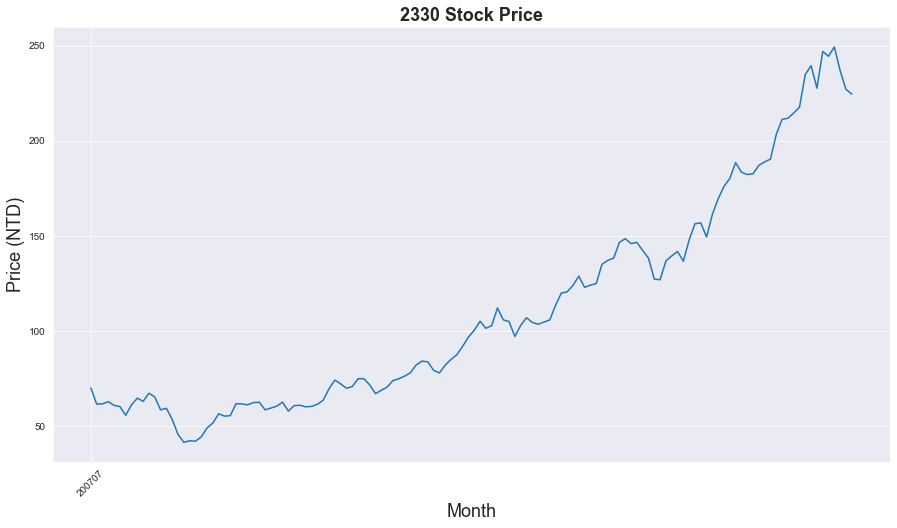

In [19]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,8))
plt.plot(data[['PRICE']])
plt.xticks(range(0,data.shape[0],1000),data['DATE'].loc[::500],rotation=45)
plt.title("2330 Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Month',fontsize=18)
plt.ylabel('Price (NTD)',fontsize=18)
plt.show()

In [20]:
multi_var_price_data = data.drop('DATE', 1)
multi_var_price_data = multi_var_price_data.to_numpy()

## 資料預處理
> 切分測試資料，將最後五個月的值作為測試資料。訓練資料的部分使用MinMaxScaler做正規化，將值轉換為介於-1至1之間的數值。得到正規化後的訓練資料維度為(127, 107)。接著轉成Tensor形式。

In [21]:
# 測試資料為最後五個月
test_data_size = 5

train_data = multi_var_price_data[:-test_data_size]
test_data = multi_var_price_data[-test_data_size:]

In [22]:
print(len(train_data))
print(len(test_data))
print(train_data)

127
5
[[ 7.02000000e+01  7.80640000e+07  7.86850000e+08 ...  0.00000000e+00
   3.60000000e+06  1.03678636e+02]
 [ 6.17300000e+01  7.80640000e+07  7.86850000e+08 ...  0.00000000e+00
   3.60000000e+06  9.32986956e+01]
 [ 6.18500000e+01  7.80640000e+07  7.86850000e+08 ...  0.00000000e+00
   3.60000000e+06  9.34205556e+01]
 ...
 [ 2.39450000e+02  9.53625380e+07  3.08061513e+09 ... -9.14048000e+05
   1.23688400e+07  1.71201364e+02]
 [ 2.27690000e+02  9.53625380e+07  3.08061513e+09 ... -9.14048000e+05
   1.23688400e+07  1.62243809e+02]
 [ 2.46950000e+02  1.06452676e+08  3.14334508e+09 ...  6.76980000e+05
   1.01560470e+07  1.73959091e+02]]


In [23]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
train_data_normalized

array([[-0.72212208,  0.45967608, -1.        , ...,  0.32605321,
        -0.59854191, -0.08216463],
       [-0.80464754,  0.45967608, -1.        , ...,  0.32605321,
        -0.59854191, -0.24199291],
       [-0.80347835,  0.45967608, -1.        , ...,  0.32605321,
        -0.59854191, -0.24011654],
       ...,
       [ 0.92692551,  0.78892052,  0.94675995, ..., -0.02306892,
         0.21273644,  0.95753706],
       [ 0.81234472,  0.78892052,  0.94675995, ..., -0.02306892,
         0.21273644,  0.8196104 ],
       [ 1.        ,  1.        ,  1.        , ...,  0.58462683,
         0.00801255,  1.        ]])

In [24]:
train_data_normalized.shape

(127, 107)

In [25]:
# transform into Tensor
# train_data_normalized = torch.FloatTensor(train_data_normalized)
train_data_normalized = torch.from_numpy(train_data_normalized).type(torch.Tensor)

> 接著將資料做序列化，時間間隔取12個月，總共有115組tuple形式的資料。

In [26]:
def make_sequence_data(input_data, num_sequence):
    data = []
    num_data = len(input_data)
    for i in range(num_data - num_sequence):
        seq_data = input_data[i:i+num_sequence]
        target_data = input_data[:,0][i+num_sequence:i+num_sequence+1]
        data.append((seq_data, target_data))

    return data

In [27]:
# 時間間隔 12個月
seq_length = 12
train_seq_data = make_sequence_data(train_data_normalized, seq_length)

In [28]:
print(len(train_seq_data))
train_seq_data

115


[(tensor([[-0.7221,  0.4597, -1.0000,  ...,  0.3261, -0.5985, -0.0822],
          [-0.8046,  0.4597, -1.0000,  ...,  0.3261, -0.5985, -0.2420],
          [-0.8035,  0.4597, -1.0000,  ...,  0.3261, -0.5985, -0.2401],
          ...,
          [-0.7907, -0.4018, -0.9575,  ...,  0.3168, -0.6075, -0.4048],
          [-0.7489, -0.4018, -0.9575,  ...,  0.3168, -0.6075, -0.3757],
          [-0.7682, -0.4018, -0.9575,  ...,  0.3168, -0.6075, -0.4805]]),
  tensor([-0.8340])),
 (tensor([[-0.8046,  0.4597, -1.0000,  ...,  0.3261, -0.5985, -0.2420],
          [-0.8035,  0.4597, -1.0000,  ...,  0.3261, -0.5985, -0.2401],
          [-0.7925,  0.4936, -0.9885,  ...,  0.3261, -0.5053, -0.2048],
          ...,
          [-0.7489, -0.4018, -0.9575,  ...,  0.3168, -0.6075, -0.3757],
          [-0.7682, -0.4018, -0.9575,  ...,  0.3168, -0.6075, -0.4805],
          [-0.8340, -0.1561, -0.9466,  ..., -0.4286, -0.5932, -0.6102]]),
  tensor([-0.8264])),
 (tensor([[-0.8035,  0.4597, -1.0000,  ...,  0.3261, -0.59

## 定義LSTM Model

> 定義LSTM模型

- input_size為107個特徵值
- criterion採用MSE計算Loss值
- 優化器使用Adam方法
- 學習率設定為0.001
- epoch設定250

In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size=features_number, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x, None)
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction

In [30]:
model = LSTM()
model.to()

LSTM(
  (lstm): LSTM(107, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [31]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 250

> 訓練模型並計算損失值，經過每一輪的訓練，其損失值漸趨收斂。

In [32]:
losses = []
for i in range(epochs):
    for seq, labels in train_seq_data:
        seq, labels = torch.unsqueeze(seq, 0), torch.unsqueeze(labels, 0)
#         seq, labels = seq.to(), labels.to()
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    losses.append(single_loss.item())
    print(f'epoch: {i}, loss : {single_loss.item()}')

epoch: 0, loss : 0.03485545888543129
epoch: 1, loss : 1.2747597793349996e-05
epoch: 2, loss : 0.010534022003412247
epoch: 3, loss : 0.00039443495916202664
epoch: 4, loss : 0.01914186403155327
epoch: 5, loss : 0.0024415941443294287
epoch: 6, loss : 0.024066712707281113
epoch: 7, loss : 0.00645857211202383
epoch: 8, loss : 0.08415080606937408
epoch: 9, loss : 0.0011927520390599966
epoch: 10, loss : 0.005344250705093145
epoch: 11, loss : 0.0009583348291926086
epoch: 12, loss : 0.010640023276209831
epoch: 13, loss : 0.0036072065122425556
epoch: 14, loss : 0.04346838593482971
epoch: 15, loss : 0.023424047976732254
epoch: 16, loss : 0.0038146446458995342
epoch: 17, loss : 0.01621997356414795
epoch: 18, loss : 5.312159032655472e-07
epoch: 19, loss : 0.014844142831861973
epoch: 20, loss : 0.0005919034592807293
epoch: 21, loss : 0.028873706236481667
epoch: 22, loss : 0.012304029427468777
epoch: 23, loss : 0.0077775320969522
epoch: 24, loss : 0.05913699418306351
epoch: 25, loss : 0.0111371139064

epoch: 206, loss : 2.4663728481755243e-07
epoch: 207, loss : 5.084320036985446e-06
epoch: 208, loss : 0.00047595411888323724
epoch: 209, loss : 0.0008337170584127307
epoch: 210, loss : 0.0039671557024121284
epoch: 211, loss : 0.001085336203686893
epoch: 212, loss : 0.004627845715731382
epoch: 213, loss : 6.847449185443111e-06
epoch: 214, loss : 0.0004143473051954061
epoch: 215, loss : 6.298767402768135e-05
epoch: 216, loss : 0.00024899246636778116
epoch: 217, loss : 0.0030498153064399958
epoch: 218, loss : 0.0005332088912837207
epoch: 219, loss : 0.0019722471479326487
epoch: 220, loss : 0.0006942356703802943
epoch: 221, loss : 0.0005155422259122133
epoch: 222, loss : 0.0005245949723757803
epoch: 223, loss : 7.49897226342e-05
epoch: 224, loss : 0.0002105515159200877
epoch: 225, loss : 0.004455632995814085
epoch: 226, loss : 0.0019122208468616009
epoch: 227, loss : 0.009479053318500519
epoch: 228, loss : 8.405821427004412e-05
epoch: 229, loss : 0.0007863715291023254
epoch: 230, loss : 0.

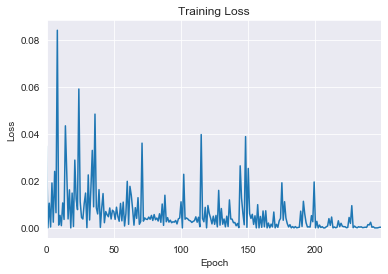

In [33]:
plt.title('Training Loss')
plt.ylabel('Loss')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(losses)
plt.xlabel('Epoch')
plt.show()

In [34]:
pred_preriod = 5
test_data_normalized = scaler.fit_transform(test_data)
# test_data_normalized = torch.FloatTensor(test_data_normalized)
test_data_normalized = torch.from_numpy(test_data_normalized).type(torch.Tensor)
test_inputs = train_data_normalized[-seq_length:].tolist()
print(len(test_inputs))

12


## 應用於預測股價

> 將測試資料投入LSTM模型做預測，結果顯示預測值與實際價格呈現相同趨勢。

In [35]:
model.eval()
test_outputs = []
for i in range(pred_preriod):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    seq = torch.unsqueeze(seq, 0)
    seq = seq.to()
    with torch.no_grad():
        test_inputs.append(test_data_normalized.tolist()[i])
        test_outputs.append(model(seq).item())

In [36]:
print(type(test_outputs))
test_outputs

<class 'list'>


[0.8154104948043823,
 0.42738258838653564,
 0.3254639506340027,
 -0.014545455574989319,
 -0.4964301586151123]

In [37]:
np_test_outputs = np.array(test_outputs).reshape(-1,1)

np_expand_test_outputs = np.pad(np_test_outputs, [(0, 0), (0, features_number-1)], mode="edge")
print(np_expand_test_outputs[0][0])
actual_predictions = scaler.inverse_transform(np_expand_test_outputs)
print(actual_predictions[0][0])
# actual_predictions = pd.DataFrame(scaler.inverse_transform(np_expand_test_outputs))
# val = actual_predictions[0].values[0]
# val

0.8154104948043823
247.08570487320424


In [38]:
x = np.arange(len_data-pred_preriod, len_data, 1)
print(x)

[127 128 129 130 131]


In [39]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size

In [40]:
actual_predictions[:,0]

array([247.08570487, 242.28385953, 241.02261639, 236.81499999,
       230.85167679])

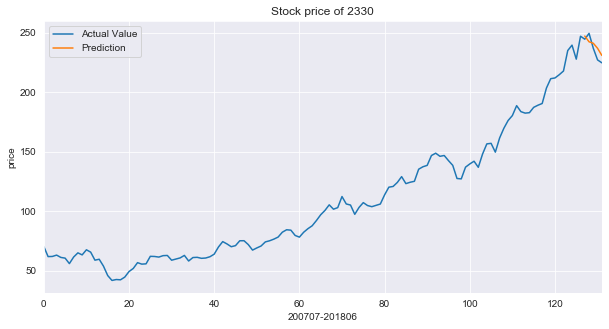

In [41]:
plt.title('Stock price of 2330')
plt.ylabel('price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['PRICE'], label='Actual Value')
plt.plot(x, actual_predictions[:,0], label='Prediction')
plt.xlabel('200707-201806')
plt.legend()
plt.show()

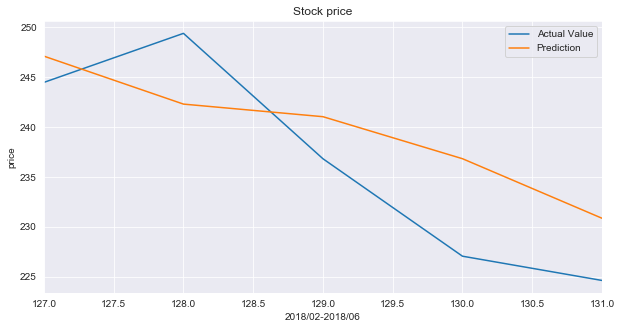

In [42]:
plt.title('Stock price')
plt.ylabel('price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x, data['PRICE'][-1*pred_preriod:], label='Actual Value')
plt.plot(x, actual_predictions[:,0], label='Prediction')
plt.xlabel('2018/02-2018/06')
plt.legend()
plt.show()